In [8]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils


OBSERVER_TYPE = "gaussian"
LESION_PCT = 0.75
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_MODULE_ID = "F5"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 60
BATCH_SIZE = 128

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type="connection",
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=35,
                                              obs_out_dim=OBS_OUT_DIM)

CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())
mike.set_lesion(lesion_instance)
mike.reset()

In [12]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True)

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 1])


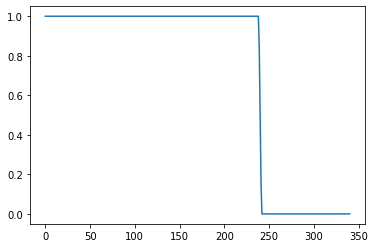

In [6]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [44]:
# Question 1: can we find the hold signal?

loss = torch.nn.MSELoss()
model = utils.LSTMModel(OBS_OUT_DIM * 2, 1, num_neurons=OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=2e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 1e-3:
    for batch in loader:
        if ll < 0.1:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        if ll < 0.02:
            for p in opt.param_groups:
                p['lr'] = 3e-5
                
        opt.zero_grad()
        
        din, trial_end, trial_len, dout, dlabel = batch
        steps = din.shape[1]
        batch_size = din.shape[0]
        
        dvis = din[:, :, :-1]
        dhold = din[:, :, -1:]
        
        mike.reset()
        model.reset()
        
        preds = torch.zeros(batch_size, steps, 1)
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer, drop_module_idx=1)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
            preds[:, tidx, :] = pred[:, :]
        
        la = loss(preds, dhold)
        la.backward()
        opt.step()
        ll = la.item()
        print(eidx, ll)
        
        eidx += 1

        
        break
    break
        
        
# Yes. That works

0 0.017514115199446678


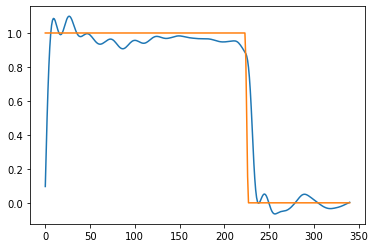

In [45]:
plt.plot(preds[1, :, 0].detach().numpy())
plt.plot(dhold[1, :, 0].detach().numpy())
plt.show()

In [16]:
# Question 2: can we separate the classes?

loss = nn.CrossEntropyLoss()
#model = utils.LSTMModel(2*OBS_OUT_DIM, 7, num_neurons=3*OBS_OUT_DIM)
#opt = AdamW(model.parameters(), lr=1e-3)#, weight_decay=0.04)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
losses = []
bail = False
while True:
    for batch in loader:
        if ll >= 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-5
        elif ll < 1:
            for p in opt.param_groups:
                p['lr'] = 3e-5
        
        din, trial_end, trial_len, dout, dlabel = batch
        
        # Let's actually see if the early trial info is enough...
        steps = din.shape[1]
        #steps = 231
        batch_size = din.shape[0]
        
        opt.zero_grad() 
        mike.reset()
        model.reset()
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)            
            
            obs = mike.observe(observer)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs[1:]]),
                            axis=1)
            pred = model(new_obs)
                
        la = loss(pred, dlabel)
        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
        print(eidx, f"{correct}/{batch_size}", la.item())
        
        if (correct / batch_size) >= 0.90:
            bail = True
            break
        
        ll = la.item()
        #if len(losses) > 5 and ll > (1.15 * sum(losses[-5:]) / 5) and losses[-1] < 1.75:
        #    print("pass")
        #else:
        la.backward()
        opt.step()
        losses.append(ll)
        
        eidx += 1
    if bail:
        break

0 377/502 0.5986960530281067
1 377/502 0.598488986492157
2 377/502 0.5982807874679565
3 377/502 0.5980730056762695
4 377/502 0.5978654623031616
5 377/502 0.5976571440696716
6 377/502 0.5974484086036682
7 377/502 0.5972407460212708
8 377/502 0.5970317721366882
9 377/502 0.5968226194381714
10 377/502 0.5966141223907471
11 377/502 0.5964040756225586
12 377/502 0.5961948037147522
13 377/502 0.5959847569465637
14 377/502 0.5957747101783752
15 378/502 0.5955638885498047
16 378/502 0.5953532457351685
17 378/502 0.5951424837112427
18 378/502 0.5949306488037109
19 378/502 0.5947185158729553
20 378/502 0.5945059657096863
21 377/502 0.5942935943603516
22 377/502 0.5940806865692139
23 377/502 0.593866229057312
24 378/502 0.5936523079872131
25 378/502 0.5934374928474426
26 378/502 0.5932223200798035
27 378/502 0.5930056571960449
28 378/502 0.5927890539169312
29 379/502 0.592572033405304
30 379/502 0.592353105545044
31 379/502 0.5921345949172974
32 379/502 0.5919147729873657
33 380/502 0.59169381856

270 362/502 0.6342321634292603
271 361/502 0.6336697340011597
272 362/502 0.6328763365745544
273 362/502 0.6318865418434143
274 362/502 0.6307328343391418
275 363/502 0.6296114325523376
276 364/502 0.6285097002983093
277 364/502 0.6275891065597534
278 362/502 0.6268540024757385
279 364/502 0.6261407136917114
280 365/502 0.6252115368843079
281 364/502 0.624381422996521
282 365/502 0.6235759854316711
283 365/502 0.622717559337616
284 365/502 0.6219061613082886
285 365/502 0.6211961507797241
286 366/502 0.6205764412879944
287 366/502 0.6198685765266418
288 367/502 0.6190890669822693
289 367/502 0.6183013319969177
290 368/502 0.6175736784934998
291 367/502 0.6169121861457825
292 368/502 0.6162466406822205
293 368/502 0.6155400276184082
294 369/502 0.6148057579994202
295 369/502 0.614064633846283
296 370/502 0.6133212447166443
297 371/502 0.6125595569610596
298 371/502 0.6117979288101196
299 371/502 0.6110210418701172
300 371/502 0.6101734638214111
301 370/502 0.60929274559021
302 369/502 0

536 391/502 0.5276407599449158
537 391/502 0.52741539478302
538 391/502 0.5271900296211243
539 391/502 0.5269646644592285
540 391/502 0.5267395377159119
541 391/502 0.5265147686004639
542 391/502 0.5262896418571472
543 391/502 0.5260650515556335
544 392/502 0.5258401036262512
545 392/502 0.5256158709526062
546 392/502 0.5253907442092896
547 392/502 0.5251660943031311
548 392/502 0.5249413847923279
549 393/502 0.5247171521186829
550 393/502 0.524492621421814
551 393/502 0.5242677330970764
552 393/502 0.5240430235862732
553 393/502 0.5238180160522461
554 393/502 0.5235927700996399
555 393/502 0.5233675837516785
556 393/502 0.5231416821479797
557 393/502 0.5229154229164124
558 393/502 0.522688090801239
559 393/502 0.5224598050117493
560 392/502 0.5222287178039551
561 392/502 0.5219948291778564
562 392/502 0.5217561721801758
563 392/502 0.5215124487876892
564 392/502 0.5212600231170654
565 392/502 0.5209993720054626
566 392/502 0.520728588104248
567 392/502 0.5204468369483948
568 392/502 0

804 190/502 1.6554253101348877
805 190/502 1.65278959274292
806 189/502 1.6501553058624268
807 188/502 1.6475142240524292
808 186/502 1.6448618173599243
809 185/502 1.64219069480896
810 186/502 1.6394933462142944
811 184/502 1.6367655992507935
812 183/502 1.6340049505233765
813 184/502 1.6312143802642822
814 183/502 1.628403663635254
815 182/502 1.6255910396575928
816 183/502 1.6228107213974
817 183/502 1.6201027631759644
818 183/502 1.6175062656402588
819 182/502 1.6150474548339844
820 183/502 1.6127238273620605
821 182/502 1.6105051040649414
822 184/502 1.6083346605300903
823 184/502 1.6061562299728394
824 185/502 1.60392427444458
825 183/502 1.6016170978546143
826 182/502 1.5992330312728882
827 180/502 1.596790075302124
828 180/502 1.596541166305542
829 180/502 1.5962855815887451
830 181/502 1.5960265398025513
831 180/502 1.5957634449005127
832 178/502 1.5954957008361816
833 180/502 1.5952287912368774
834 180/502 1.5949593782424927
835 179/502 1.5946886539459229
836 179/502 1.594418

1069 211/502 1.468068242073059
1070 210/502 1.4675897359848022
1071 210/502 1.4671111106872559
1072 210/502 1.466633677482605
1073 210/502 1.466155767440796
1074 210/502 1.4656785726547241
1075 210/502 1.4652013778686523
1076 210/502 1.4647246599197388
1077 211/502 1.4642492532730103
1078 211/502 1.463773250579834
1079 211/502 1.4632972478866577
1080 210/502 1.4628218412399292
1081 210/502 1.4623461961746216
1082 209/502 1.4618713855743408
1083 209/502 1.46139657497406
1084 209/502 1.4609224796295166
1085 209/502 1.4604483842849731
1086 209/502 1.4599753618240356
1087 209/502 1.4595032930374146
1088 209/502 1.4590293169021606
1089 210/502 1.4585576057434082
1090 210/502 1.4580860137939453
1091 210/502 1.4576137065887451
1092 210/502 1.45714271068573
1093 210/502 1.4566729068756104
1094 210/502 1.4562016725540161
1095 210/502 1.4557334184646606
1096 209/502 1.455263376235962
1097 209/502 1.4547948837280273
1098 210/502 1.4543261528015137
1099 209/502 1.453857660293579
1100 209/502 1.453

1328 234/502 1.335670828819275
1329 234/502 1.3353102207183838
1330 234/502 1.334951400756836
1331 234/502 1.3345917463302612
1332 234/502 1.3342331647872925
1333 234/502 1.3338745832443237
1334 234/502 1.333518624305725
1335 234/502 1.3331619501113892
1336 234/502 1.3328044414520264
1337 234/502 1.3324482440948486
1338 234/502 1.332092523574829
1339 234/502 1.33173668384552
1340 236/502 1.3313814401626587
1341 236/502 1.3310269117355347
1342 236/502 1.3306723833084106
1343 236/502 1.3303180932998657
1344 236/502 1.3299634456634521
1345 236/502 1.3296098709106445
1346 237/502 1.3292557001113892
1347 237/502 1.3289015293121338
1348 237/502 1.328546404838562
1349 237/502 1.3281917572021484
1350 237/502 1.3278378248214722
1351 237/502 1.3274834156036377
1352 237/502 1.3271281719207764
1353 236/502 1.3267734050750732
1354 236/502 1.326418399810791
1355 236/502 1.3260616064071655
1356 236/502 1.3257068395614624
1357 235/502 1.3253505229949951
1358 235/502 1.3249965906143188
1359 235/502 1.3

1587 233/502 1.2569307088851929
1588 233/502 1.2566635608673096
1589 233/502 1.2563976049423218
1590 233/502 1.2561315298080444
1591 233/502 1.2558645009994507
1592 233/502 1.255598783493042
1593 233/502 1.2553327083587646
1594 233/502 1.255067229270935
1595 233/502 1.254801630973816
1596 234/502 1.25453519821167
1597 234/502 1.2542697191238403
1598 234/502 1.2540041208267212
1599 234/502 1.2537388801574707
1600 234/502 1.2534730434417725
1601 234/502 1.253208041191101
1602 234/502 1.2529431581497192
1603 234/502 1.2526774406433105
1604 234/502 1.2524124383926392
1605 235/502 1.2521471977233887
1606 235/502 1.2518818378448486
1607 235/502 1.2516168355941772
1608 235/502 1.2513525485992432
1609 235/502 1.2510871887207031
1610 235/502 1.250822901725769
1611 235/502 1.250558614730835
1612 235/502 1.2502943277359009
1613 235/502 1.2500282526016235
1614 235/502 1.2497649192810059
1615 235/502 1.2495001554489136
1616 235/502 1.2492355108261108
1617 235/502 1.248970866203308
1618 235/502 1.24

1846 241/502 1.1926888227462769
1847 241/502 1.1924514770507812
1848 241/502 1.1922142505645752
1849 241/502 1.191977620124817
1850 241/502 1.191739797592163
1851 241/502 1.1915032863616943
1852 241/502 1.191266417503357
1853 241/502 1.1910291910171509
1854 241/502 1.1907916069030762
1855 241/502 1.1905549764633179
1856 241/502 1.190319299697876
1857 241/502 1.19008207321167
1858 241/502 1.1898449659347534
1859 241/502 1.1896086931228638
1860 241/502 1.1893725395202637
1861 241/502 1.189136266708374
1862 241/502 1.188899040222168
1863 241/502 1.1886636018753052
1864 241/502 1.1884270906448364
1865 241/502 1.1881914138793945
1866 241/502 1.1879554986953735
1867 241/502 1.1877200603485107
1868 241/502 1.187483787536621
1869 241/502 1.1872485876083374
1870 241/502 1.1870125532150269
1871 241/502 1.1867762804031372
1872 241/502 1.1865414381027222
1873 241/502 1.186306118965149
1874 241/502 1.186071515083313
1875 241/502 1.185835599899292
1876 241/502 1.1856002807617188
1877 241/502 1.18536

2108 202/502 1.9257756471633911
2109 202/502 1.925706386566162
2110 202/502 1.9256377220153809
2111 202/502 1.9255722761154175
2112 202/502 1.925510287284851
2113 201/502 1.9254510402679443
2114 200/502 1.9253932237625122
2115 203/502 1.9253389835357666
2116 189/502 1.925285816192627
2117 200/502 1.9252337217330933
2118 207/502 1.9251827001571655
2119 201/502 1.9251331090927124
2120 201/502 1.925083875656128
2121 197/502 1.9250354766845703
2122 190/502 1.9249874353408813
2123 187/502 1.9249390363693237
2124 186/502 1.924891471862793
2125 181/502 1.9248435497283936
2126 179/502 1.9247934818267822
2127 177/502 1.924746036529541
2128 177/502 1.924696445465088
2129 180/502 1.924647569656372
2130 180/502 1.9245977401733398
2131 181/502 1.9245489835739136
2132 176/502 1.9244974851608276
2133 177/502 1.9244471788406372
2134 176/502 1.9243961572647095
2135 175/502 1.9243460893630981
2136 175/502 1.9242945909500122
2137 176/502 1.9242453575134277
2138 178/502 1.924193263053894
2139 176/502 1.92

2367 216/502 1.9081109762191772
2368 216/502 1.9080053567886353
2369 216/502 1.9078969955444336
2370 216/502 1.907788872718811
2371 216/502 1.907680869102478
2372 215/502 1.9075729846954346
2373 215/502 1.907462477684021
2374 215/502 1.907353162765503
2375 215/502 1.907243013381958
2376 214/502 1.9071296453475952
2377 215/502 1.9070191383361816
2378 215/502 1.9069054126739502
2379 215/502 1.9067935943603516
2380 215/502 1.9066797494888306
2381 215/502 1.9065666198730469
2382 215/502 1.9064513444900513
2383 215/502 1.906335473060608
2384 215/502 1.9062196016311646
2385 214/502 1.9061022996902466
2386 214/502 1.905985951423645
2387 214/502 1.905866265296936
2388 215/502 1.9057481288909912
2389 215/502 1.9056295156478882
2390 215/502 1.9055097103118896
2391 215/502 1.9053881168365479
2392 215/502 1.905266284942627
2393 215/502 1.9051454067230225
2394 215/502 1.9050215482711792
2395 214/502 1.9048973321914673
2396 214/502 1.9047733545303345
2397 214/502 1.904648780822754
2398 214/502 1.904

2626 166/502 1.4924262762069702
2627 168/502 1.4908263683319092
2628 169/502 1.4892319440841675
2629 169/502 1.4876439571380615
2630 169/502 1.4860587120056152
2631 169/502 1.4844775199890137
2632 171/502 1.4829027652740479
2633 171/502 1.481331706047058
2634 172/502 1.4797629117965698
2635 173/502 1.4781994819641113
2636 174/502 1.4766405820846558
2637 175/502 1.4750839471817017
2638 176/502 1.4735331535339355
2639 176/502 1.4719854593276978
2640 181/502 1.47044038772583
2641 181/502 1.4689016342163086
2642 181/502 1.4673655033111572
2643 181/502 1.4658323526382446
2644 181/502 1.4643020629882812
2645 182/502 1.4627768993377686
2646 183/502 1.4612525701522827
2647 186/502 1.4597325325012207
2648 187/502 1.4582157135009766
2649 189/502 1.4567017555236816
2650 189/502 1.455189824104309
2651 189/502 1.4536808729171753
2652 189/502 1.4521745443344116
2653 190/502 1.4506717920303345
2654 191/502 1.4491710662841797
2655 192/502 1.4476733207702637
2656 191/502 1.4461770057678223
2657 191/502

2885 249/502 1.1729092597961426
2886 250/502 1.1716002225875854
2887 250/502 1.1703046560287476
2888 250/502 1.1689852476119995
2889 250/502 1.1676714420318604
2890 249/502 1.166335940361023
2891 250/502 1.1649999618530273
2892 251/502 1.1636403799057007
2893 250/502 1.1622735261917114
2894 251/502 1.1608768701553345
2895 251/502 1.1594693660736084
2896 252/502 1.1580283641815186
2897 253/502 1.1565748453140259
2898 251/502 1.1551120281219482
2899 251/502 1.1537243127822876
2900 254/502 1.152346134185791
2901 252/502 1.15079927444458
2902 254/502 1.1493390798568726
2903 254/502 1.147943377494812
2904 255/502 1.1465177536010742
2905 253/502 1.1450302600860596
2906 253/502 1.1435291767120361
2907 254/502 1.142120122909546
2908 254/502 1.1406947374343872
2909 253/502 1.1391874551773071
2910 252/502 1.137759804725647
2911 252/502 1.1363261938095093
2912 252/502 1.1348334550857544
2913 253/502 1.1333444118499756
2914 255/502 1.1318944692611694
2915 255/502 1.1303898096084595
2916 255/502 1.

3143 299/502 1.0389442443847656
3144 331/502 0.9085728526115417
3145 316/502 0.9628490209579468
3146 308/502 0.9827829599380493
3147 317/502 0.9604791402816772
3148 336/502 0.9133151173591614
3149 343/502 0.889423131942749
3150 331/502 0.9187341928482056
3151 323/502 0.9326947927474976
3152 344/502 0.8874188661575317
3153 344/502 0.8872184157371521
3154 340/502 0.8951483368873596
3155 334/502 0.9054219126701355
3156 342/502 0.8810907006263733
3157 339/502 0.8670763969421387
3158 350/502 0.8609922528266907
3159 325/502 0.8791114091873169
3160 334/502 0.8649557828903198
3161 348/502 0.8586944937705994
3162 341/502 0.8626147508621216
3163 343/502 0.8622422218322754
3164 344/502 0.8590050339698792
3165 350/502 0.84934401512146
3166 341/502 0.867812991142273
3167 309/502 0.9777168035507202
3168 284/502 1.0575580596923828
3169 288/502 1.0501292943954468
3170 294/502 1.0205222368240356
3171 312/502 0.9741719961166382
3172 318/502 0.9337733387947083
3173 318/502 0.9270761013031006
3174 317/502

3400 238/502 1.1176706552505493
3401 233/502 1.1081966161727905
3402 229/502 1.0989770889282227
3403 225/502 1.0900518894195557
3404 222/502 1.0814862251281738
3405 224/502 1.0733507871627808
3406 226/502 1.0657224655151367
3407 227/502 1.0586647987365723
3408 226/502 1.0522239208221436
3409 229/502 1.0464178323745728
3410 231/502 1.0412365198135376
3411 231/502 1.0366460084915161
3412 235/502 1.0325875282287598
3413 240/502 1.0289888381958008
3414 241/502 1.0257681608200073
3415 244/502 1.0228468179702759
3416 246/502 1.0201448202133179
3417 247/502 1.0175979137420654
3418 252/502 1.0151538848876953
3419 251/502 1.01277756690979
3420 252/502 1.010450005531311
3421 250/502 1.0081654787063599
3422 252/502 1.0059266090393066
3423 254/502 1.00373113155365
3424 252/502 1.0015746355056763
3425 254/502 0.9994493722915649
3426 256/502 0.9973482489585876
3427 258/502 0.9952647089958191
3428 259/502 0.9931909441947937
3429 260/502 0.991120457649231
3430 262/502 0.9890424609184265
3431 261/502 0

3657 343/502 0.7361067533493042
3658 344/502 0.7356395125389099
3659 344/502 0.7351763248443604
3660 343/502 0.7347176671028137
3661 344/502 0.7342621684074402
3662 344/502 0.7338095307350159
3663 344/502 0.7333607077598572
3664 344/502 0.7329140901565552
3665 344/502 0.7324707508087158
3666 344/502 0.732029914855957
3667 344/502 0.7315928936004639
3668 344/502 0.7311568260192871
3669 345/502 0.7307237982749939
3670 346/502 0.7302927374839783
3671 346/502 0.7298649549484253
3672 346/502 0.729438304901123
3673 346/502 0.7290137410163879
3674 346/502 0.7285912036895752
3675 346/502 0.7281708121299744
3676 346/502 0.727752149105072
3677 346/502 0.7273353934288025
3678 346/502 0.7269208431243896
3679 346/502 0.7265064120292664
3680 346/502 0.7260948419570923
3681 346/502 0.7256840467453003
3682 346/502 0.7252752780914307
3683 346/502 0.7248679399490356
3684 346/502 0.7244609594345093
3685 346/502 0.7240557670593262
3686 346/502 0.7236520648002625
3687 347/502 0.7232489585876465
3688 347/50

3915 367/502 0.5968936085700989
3916 367/502 0.5964049100875854
3917 367/502 0.5959181785583496
3918 367/502 0.5954311490058899
3919 367/502 0.5949450135231018
3920 367/502 0.5944597721099854
3921 367/502 0.5939751267433167
3922 367/502 0.5934909582138062
3923 367/502 0.5930079817771912
3924 367/502 0.5925260782241821
3925 367/502 0.5920451283454895
3926 367/502 0.5915647745132446
3927 366/502 0.5910862684249878
3928 366/502 0.5906084775924683
3929 366/502 0.5901322960853577
3930 366/502 0.5896582007408142
3931 366/502 0.5891849994659424
3932 366/502 0.588714063167572
3933 366/502 0.5882449746131897
3934 366/502 0.5877783894538879
3935 366/502 0.5873137712478638
3936 366/502 0.5868520736694336
3937 366/502 0.5863927006721497
3938 366/502 0.5859366655349731
3939 366/502 0.5854835510253906
3940 366/502 0.5850337743759155
3941 366/502 0.5845881104469299
3942 367/502 0.5841460824012756
3943 367/502 0.5837082266807556
3944 368/502 0.5832749605178833
3945 369/502 0.5828458666801453
3946 369/

4172 352/502 0.639858067035675
4173 349/502 0.6386370658874512
4174 346/502 0.6380934715270996
4175 346/502 0.6378213763237
4176 346/502 0.6375653147697449
4177 346/502 0.6370964050292969
4178 346/502 0.6362667679786682
4179 347/502 0.6350529193878174
4180 348/502 0.6335393786430359
4181 350/502 0.6318809390068054
4182 352/502 0.6302991509437561
4183 354/502 0.6291288733482361
4184 357/502 0.6287596821784973
4185 357/502 0.6379051804542542
4186 353/502 0.6309572458267212
4187 346/502 0.6405725479125977
4188 345/502 0.6516368985176086
4189 346/502 0.6587530970573425
4190 348/502 0.6540473699569702
4191 349/502 0.6442344784736633
4192 351/502 0.6352357268333435
4193 350/502 0.6290152072906494
4194 352/502 0.6305079460144043
4195 348/502 0.6353123188018799
4196 343/502 0.6415637135505676
4197 343/502 0.6403723359107971
4198 349/502 0.6329585313796997
4199 351/502 0.6272500157356262
4200 355/502 0.6239210963249207
4201 355/502 0.6257600784301758
4202 352/502 0.6277031302452087
4203 352/502

4430 381/502 0.5151159167289734
4431 381/502 0.514999508857727
4432 381/502 0.5148829221725464
4433 381/502 0.514767050743103
4434 381/502 0.5146511793136597
4435 381/502 0.514535129070282
4436 381/502 0.5144193768501282
4437 381/502 0.5143041610717773
4438 381/502 0.514188826084137
4439 381/502 0.5140736699104309
4440 381/502 0.5139585733413696
4441 381/502 0.5138437747955322
4442 381/502 0.51372891664505
4443 381/502 0.5136143565177917
4444 381/502 0.5134997963905334
4445 381/502 0.5133853554725647
4446 381/502 0.5132709741592407
4447 381/502 0.5131563544273376
4448 381/502 0.513042151927948
4449 382/502 0.5129280686378479
4450 382/502 0.5128138065338135
4451 382/502 0.5126999616622925
4452 381/502 0.5125857591629028
4453 380/502 0.5124720335006714
4454 380/502 0.5123583078384399
4455 380/502 0.5122443437576294
4456 380/502 0.5121307969093323
4457 380/502 0.512016773223877
4458 380/502 0.5119028091430664
4459 380/502 0.5117897391319275
4460 380/502 0.5116760730743408
4461 380/502 0.5

4688 383/502 0.4979097247123718
4689 382/502 0.496738463640213
4690 382/502 0.49711185693740845
4691 382/502 0.4962720274925232
4692 382/502 0.4960688054561615
4693 383/502 0.4961276054382324
4694 382/502 0.49528226256370544
4695 383/502 0.495487242937088
4696 383/502 0.49531298875808716
4697 383/502 0.49451038241386414
4698 384/502 0.4947892725467682
4699 384/502 0.4943690299987793
4700 385/502 0.4938482344150543
4701 385/502 0.4940393567085266
4702 386/502 0.4934421181678772
4703 386/502 0.49325159192085266
4704 385/502 0.4932181239128113
4705 385/502 0.4926857352256775
4706 386/502 0.4926639199256897
4707 385/502 0.49247726798057556
4708 385/502 0.49209707975387573
4709 386/502 0.4920792877674103
4710 385/502 0.49183452129364014
4711 385/502 0.4915443956851959
4712 386/502 0.4914795756340027
4713 385/502 0.49123188853263855
4714 385/502 0.49099528789520264
4715 386/502 0.4909045696258545
4716 385/502 0.4906800091266632
4717 385/502 0.4904736876487732
4718 386/502 0.4903687834739685


4943 380/502 0.5013850927352905
4944 379/502 0.5001254677772522
4945 383/502 0.4952268898487091
4946 378/502 0.5023752450942993
4947 382/502 0.493097186088562
4948 380/502 0.49523666501045227
4949 380/502 0.4944223463535309
4950 383/502 0.4900595545768738
4951 379/502 0.4944640100002289
4952 382/502 0.4874380826950073
4953 374/502 0.4981347620487213
4954 379/502 0.4858117997646332
4955 377/502 0.49009719491004944
4956 380/502 0.4847449064254761
4957 380/502 0.48828020691871643
4958 376/502 0.4870593547821045
4959 380/502 0.4850017726421356
4960 381/502 0.4834400713443756
4961 382/502 0.4851571023464203
4962 381/502 0.48205482959747314
4963 380/502 0.48491454124450684
4964 382/502 0.48059502243995667
4965 383/502 0.4836142957210541
4966 383/502 0.4795755445957184
4967 382/502 0.48183125257492065
4968 382/502 0.47861525416374207
4969 385/502 0.4799319803714752
4970 385/502 0.4775676131248474
4971 383/502 0.478132963180542
4972 384/502 0.4768753945827484
4973 385/502 0.47673800587654114
4

5196 393/502 0.4446466863155365
5197 393/502 0.4445534348487854
5198 393/502 0.44446006417274475
5199 393/502 0.4443666636943817
5200 393/502 0.4442738890647888
5201 393/502 0.44418084621429443
5202 393/502 0.44408801198005676
5203 393/502 0.4439953863620758
5204 394/502 0.4439024031162262
5205 394/502 0.4438093900680542
5206 394/502 0.443716824054718
5207 394/502 0.44362398982048035
5208 394/502 0.4435313642024994
5209 394/502 0.44343918561935425
5210 394/502 0.4433465898036957
5211 394/502 0.4432540833950043
5212 394/502 0.44316160678863525
5213 394/502 0.4430690109729767
5214 395/502 0.44297677278518677
5215 395/502 0.4428843557834625
5216 395/502 0.44279244542121887
5217 395/502 0.4426998496055603
5218 397/502 0.4426077902317047
5219 397/502 0.44251561164855957
5220 397/502 0.4424235224723816
5221 398/502 0.44233110547065735
5222 399/502 0.44223952293395996
5223 399/502 0.4421476423740387
5224 399/502 0.4420554041862488
5225 399/502 0.4419638216495514
5226 399/502 0.441871762275695

5450 401/502 0.4254065752029419
5451 401/502 0.425285667181015
5452 401/502 0.4251652657985687
5453 401/502 0.42504459619522095
5454 401/502 0.42492425441741943
5455 401/502 0.4248042404651642
5456 401/502 0.42468440532684326
5457 401/502 0.42456454038619995
5458 402/502 0.4244450032711029
5459 402/502 0.4243255853652954
5460 402/502 0.4242062568664551
5461 402/502 0.4240867793560028
5462 402/502 0.42396795749664307
5463 402/502 0.4238486886024475
5464 402/502 0.42372995615005493
5465 402/502 0.42361122369766235
5466 402/502 0.4234926104545593
5467 403/502 0.4233737885951996
5468 403/502 0.42325544357299805
5469 403/502 0.4231370985507965
5470 403/502 0.4230187237262726
5471 403/502 0.42289999127388
5472 403/502 0.42278194427490234
5473 403/502 0.42266371846199036
5474 403/502 0.42254573106765747
5475 403/502 0.4224274456501007
5476 403/502 0.42230919003486633
5477 403/502 0.4221912622451782
5478 403/502 0.42207321524620056
5479 403/502 0.4219549596309662
5480 403/502 0.421836942434310

5704 402/502 0.40808427333831787
5705 404/502 0.40791264176368713
5706 404/502 0.40774232149124146
5707 404/502 0.40757283568382263
5708 404/502 0.4074040353298187
5709 404/502 0.4072360098361969
5710 405/502 0.4070684015750885
5711 405/502 0.40690165758132935
5712 405/502 0.4067362844944
5713 405/502 0.4065709114074707
5714 405/502 0.40640610456466675
5715 406/502 0.40624192357063293
5716 406/502 0.40607866644859314
5717 406/502 0.40591588616371155
5718 406/502 0.4057539999485016
5719 406/502 0.4055916666984558
5720 406/502 0.4054310619831085
5721 406/502 0.40527012944221497
5722 406/502 0.4051101803779602
5723 406/502 0.4049505591392517
5724 406/502 0.4047909080982208
5725 406/502 0.40463241934776306
5726 406/502 0.404474139213562
5727 406/502 0.4043163061141968
5728 406/502 0.4041588604450226
5729 406/502 0.4040015637874603
5730 406/502 0.40384483337402344
5731 406/502 0.40368857979774475
5732 406/502 0.4035326838493347
5733 407/502 0.4033771753311157
5734 407/502 0.4032218158245086

5958 418/502 0.3678537905216217
5959 419/502 0.36770913004875183
5960 419/502 0.3675713539123535
5961 418/502 0.3674532175064087
5962 418/502 0.367382675409317
5963 418/502 0.36755144596099854
5964 417/502 0.37023618817329407
5965 399/502 0.48699092864990234
5966 412/502 0.3859724700450897
5967 384/502 0.5914490222930908
5968 380/502 0.6107115149497986
5969 388/502 0.5440728664398193
5970 395/502 0.5058228969573975
5971 373/502 0.6334967017173767
5972 367/502 0.6436572074890137
5973 372/502 0.5876856446266174
5974 390/502 0.4801689386367798
5975 350/502 0.807680606842041
5976 339/502 0.9420320987701416
5977 372/502 0.6490678191184998
5978 370/502 0.5960315465927124
5979 351/502 0.7194130420684814
5980 328/502 0.8908019065856934
5981 320/502 0.9807034730911255
5982 323/502 0.9533114433288574
5983 335/502 0.8209105134010315
5984 351/502 0.7108644247055054
5985 368/502 0.6109979152679443
5986 367/502 0.5688296556472778
5987 359/502 0.6589048504829407
5988 355/502 0.7074878215789795
5989 3

6212 422/502 0.34263187646865845
6213 422/502 0.34245720505714417
6214 422/502 0.34228530526161194
6215 422/502 0.3421004116535187
6216 422/502 0.34192943572998047
6217 424/502 0.34175702929496765
6218 423/502 0.34157684445381165
6219 423/502 0.3414081931114197
6220 424/502 0.341234415769577
6221 424/502 0.3410583436489105
6222 424/502 0.3408903479576111
6223 424/502 0.34071627259254456
6224 424/502 0.3405442535877228
6225 424/502 0.34037625789642334
6226 424/502 0.34020376205444336
6227 425/502 0.340035080909729
6228 425/502 0.33986717462539673
6229 425/502 0.3396962881088257
6230 426/502 0.3395295739173889
6231 426/502 0.3393610715866089
6232 426/502 0.33919259905815125
6233 426/502 0.3390269875526428
6234 426/502 0.3388589918613434
6235 426/502 0.33869314193725586
6236 426/502 0.3385276198387146
6237 427/502 0.3383612334728241
6238 427/502 0.33819714188575745
6239 427/502 0.33803170919418335
6240 428/502 0.33786699175834656
6241 428/502 0.33770325779914856
6242 428/502 0.33753916621

6466 421/502 0.3442644774913788
6467 414/502 0.37596890330314636
6468 428/502 0.32175758481025696
6469 421/502 0.34521231055259705
6470 429/502 0.3186855912208557
6471 423/502 0.3548419773578644
6472 427/502 0.33227893710136414
6473 421/502 0.35872581601142883
6474 436/502 0.32046759128570557
6475 421/502 0.38582974672317505
6476 435/502 0.32150998711586
6477 426/502 0.3553241789340973
6478 435/502 0.3237806558609009
6479 428/502 0.3411686420440674
6480 435/502 0.3182220458984375
6481 436/502 0.32649660110473633
6482 436/502 0.32074302434921265
6483 436/502 0.3172600567340851
6484 433/502 0.3237825632095337
6485 437/502 0.31731560826301575
6486 435/502 0.3270442485809326
6487 437/502 0.3162294328212738
6488 435/502 0.3213087320327759
6489 436/502 0.3137187659740448
6490 434/502 0.31588292121887207
6491 433/502 0.315327912569046
6492 433/502 0.31328535079956055
6493 432/502 0.3151777386665344
6494 434/502 0.31273168325424194
6495 434/502 0.31450632214546204
6496 432/502 0.31301552057266

6720 437/502 0.28370678424835205
6721 437/502 0.28354430198669434
6722 437/502 0.2833721339702606
6723 437/502 0.2832125127315521
6724 437/502 0.2830359637737274
6725 438/502 0.2828591763973236
6726 438/502 0.28268417716026306
6727 438/502 0.282505601644516
6728 438/502 0.2823330760002136
6729 438/502 0.28215134143829346
6730 437/502 0.281975120306015
6731 436/502 0.28180402517318726
6732 436/502 0.28162887692451477
6733 436/502 0.28145700693130493
6734 436/502 0.28128647804260254
6735 436/502 0.28112003207206726
6736 436/502 0.2809550166130066
6737 436/502 0.280789315700531
6738 436/502 0.28063029050827026
6739 436/502 0.2804712653160095
6740 436/502 0.2803126275539398
6741 436/502 0.280158132314682
6742 436/502 0.28000372648239136
6743 436/502 0.2798503339290619
6744 436/502 0.27969813346862793
6745 436/502 0.27954694628715515
6746 436/502 0.27939605712890625
6747 436/502 0.27924463152885437
6748 436/502 0.27909448742866516
6749 436/502 0.2789439857006073
6750 436/502 0.2787930667400

6974 444/502 0.2654353380203247
6975 444/502 0.265310138463974
6976 444/502 0.26518717408180237
6977 444/502 0.26506277918815613
6978 444/502 0.26494100689888
6979 444/502 0.2648182809352875
6980 444/502 0.26469728350639343
6981 444/502 0.26457664370536804
6982 444/502 0.2644563615322113
6983 444/502 0.2643374800682068
6984 444/502 0.26421836018562317
6985 444/502 0.2641007900238037
6986 444/502 0.2639831602573395
6987 444/502 0.2638658583164215
6988 444/502 0.2637494206428528
6989 443/502 0.26363298296928406
6990 443/502 0.263517290353775
6991 443/502 0.26340174674987793
6992 443/502 0.2632865011692047
6993 443/502 0.2631717622280121
6994 443/502 0.26305708289146423
6995 443/502 0.26294296979904175
6996 443/502 0.2628292143344879
6997 443/502 0.2627156972885132
6998 443/502 0.26260265707969666
6999 444/502 0.26248982548713684
7000 444/502 0.2623773515224457
7001 445/502 0.26226523518562317
7002 445/502 0.2621537148952484
7003 445/502 0.26204222440719604
7004 446/502 0.2619313895702362

7227 446/502 0.25168076157569885
7228 446/502 0.2515673041343689
7229 446/502 0.251455157995224
7230 446/502 0.25134456157684326
7231 446/502 0.2512350082397461
7232 446/502 0.251126766204834
7233 447/502 0.25101932883262634
7234 447/502 0.2509132921695709
7235 447/502 0.25080764293670654
7236 447/502 0.2507031559944153
7237 447/502 0.2505989670753479
7238 447/502 0.2504957318305969
7239 447/502 0.2503930330276489
7240 447/502 0.2502909004688263
7241 447/502 0.25018948316574097
7242 447/502 0.2500881552696228
7243 447/502 0.24998746812343597
7244 447/502 0.24988770484924316
7245 447/502 0.2497878074645996
7246 447/502 0.24968872964382172
7247 447/502 0.24958987534046173
7248 447/502 0.2494915872812271
7249 447/502 0.24939362704753876
7250 448/502 0.24929627776145935
7251 448/502 0.2491990327835083
7252 448/502 0.24910256266593933
7253 448/502 0.24900630116462708
7254 448/502 0.24891041219234467
7255 448/502 0.24881508946418762
7256 448/502 0.24872003495693207
7257 448/502 0.24862517416

7480 399/502 0.44725295901298523
7481 417/502 0.36377760767936707
7482 419/502 0.37784814834594727
7483 408/502 0.4014890789985657
7484 420/502 0.34991493821144104
7485 418/502 0.3561074435710907
7486 414/502 0.37191206216812134
7487 425/502 0.34038886427879333
7488 420/502 0.3408336639404297
7489 419/502 0.35724756121635437
7490 428/502 0.3274245858192444
7491 427/502 0.33771103620529175
7492 416/502 0.37003910541534424
7493 434/502 0.3190402388572693
7494 425/502 0.33882251381874084
7495 424/502 0.34293344616889954
7496 431/502 0.3185257315635681
7497 426/502 0.33705568313598633
7498 425/502 0.3370371162891388
7499 431/502 0.31943535804748535
7500 429/502 0.32859498262405396
7501 431/502 0.3243226706981659
7502 432/502 0.318875253200531
7503 429/502 0.3266036808490753
7504 431/502 0.31558161973953247
7505 431/502 0.31901630759239197
7506 431/502 0.3181113004684448
7507 432/502 0.3122352063655853
7508 429/502 0.31703633069992065
7509 431/502 0.31117698550224304
7510 432/502 0.31449982

7734 408/502 0.47399401664733887
7735 418/502 0.38170450925827026
7736 408/502 0.4342159628868103
7737 399/502 0.505131721496582
7738 405/502 0.44680434465408325
7739 422/502 0.3881639242172241
7740 410/502 0.4063078761100769
7741 416/502 0.4238792955875397
7742 416/502 0.4001839756965637
7743 432/502 0.3728164732456207
7744 422/502 0.4027242660522461
7745 415/502 0.4131160080432892
7746 424/502 0.3763798773288727
7747 426/502 0.3856422007083893
7748 427/502 0.39621689915657043
7749 432/502 0.34650519490242004
7750 427/502 0.3519130349159241
7751 422/502 0.3677632510662079
7752 426/502 0.3467848300933838
7753 431/502 0.33157792687416077
7754 424/502 0.344165176153183
7755 423/502 0.3458924889564514
7756 433/502 0.3254956901073456
7757 433/502 0.3227292001247406
7758 433/502 0.32749703526496887
7759 436/502 0.322780966758728
7760 437/502 0.3254259526729584
7761 444/502 0.3089398443698883
7762 440/502 0.3078431785106659
7763 438/502 0.314992755651474
7764 440/502 0.3085622489452362
7765 

In [17]:
torch.save(model.state_dict(), "classifier_model")

454/502


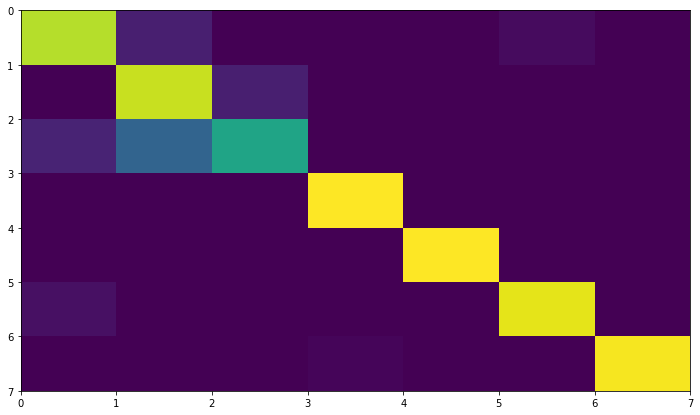

In [29]:
# Calc confusion matrix over whole data set
din, trial_end, trial_len, dout, dlabel = next(iter(loader))
assert din.shape[0] == len(dataset)

batch_size = din.shape[0]
steps = din.shape[1]

mike.reset()
model.reset()

for tidx in range(steps):
    mike_in = din[:, tidx, :].T
    mike(mike_in)
    
    obs = mike.observe(observer)
    new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs[1:]]),
                    axis=1)
    pred = model(new_obs)


correct = 0
confusion_matrix = torch.zeros(7, 7)
for x in range(batch_size):
    m = torch.argmax(pred[x, :])
    if m == dlabel[x]:
        correct += 1
        
    confusion_matrix[dlabel[x], m] += 1.0
print(f"{correct}/{batch_size}")

confusion_matrix /= confusion_matrix.sum(axis=1)

plt.figure(figsize = (12,7))
plt.gca().invert_yaxis()
plt.pcolormesh(confusion_matrix)

In [136]:
print(new_obs[0, 40:])

tensor([2.2968e-05, 3.3119e-01, 2.4881e-01, 6.2111e-03, 2.5865e-02, 1.6499e-01,
        2.8937e-01, 2.9962e-01, 1.8222e-01, 1.4834e-01, 9.6375e-02, 2.0563e-02,
        1.1619e-01, 4.6002e-01, 4.8300e-02, 3.7242e-02, 1.8442e-02, 1.7884e-01,
        2.0003e-01, 1.5599e-01])


In [ ]:
#1.29 on obs dim 45 / 50% lesion
# 75% full observation: <1 if run overnight. 64
# 75% full observation, higher learning rate - didn't converge?
# 100%, AIP only, 64, extra neurons 1.2ish
# 75% full observation, 32 1.6ish
# 75% full observation, 5x, 64 - never fell
# no lesion, 32, full observation 3 + 1 > .58
# no lesion, 64, full observation, 3 + 1 > 0.52  (maybe sam as prior)
# obs dim 20 (in progress), no lesion: 0.5 !
# lesion m1 100%, fully observe AIP, F5: 0.42 !!
# lesion connection F5<->M1, observe the rest, 20 -> 0.49